<a href="https://colab.research.google.com/github/pabloisaiahs/DS-4002-proj2-MI3/blob/main/SCRIPTS/forecasting_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression Analysis Including GDP

In this section, we present the results of our multiple linear regression model that includes GDP as one of the predictors. This model examines how economic indicators—including GDP along with CPIChange, UnemploymentRate, GDPchange, PctVotes, and categorical variables (PrezParty, Chamber, and ChamberParty)—influence presidential approval ratings.

*Key points:*
- All available predictors are included.
- The impact of GDP on the model’s explanatory power is assessed.
- Diagnostic plots and statistical tests are provided to validate the model.


<ipython-input-43-a119906bde60>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Full Model Summary (without ChamberParty):
                            OLS Regression Results                            
Dep. Variable:               Approval   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     17.01
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           6.21e-15
Time:                        02:13:41   Log-Likelihood:                -561.49
No. Observations:                 157   AIC:                             1137.
Df Residuals:                     150   BIC:                             1158.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

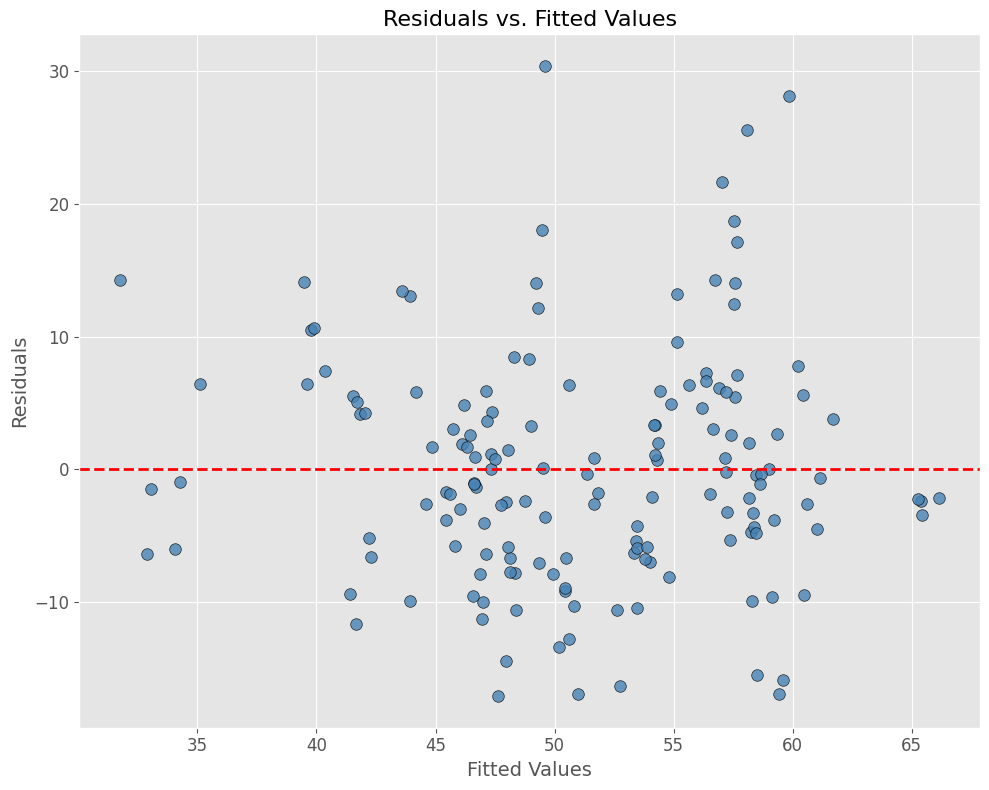

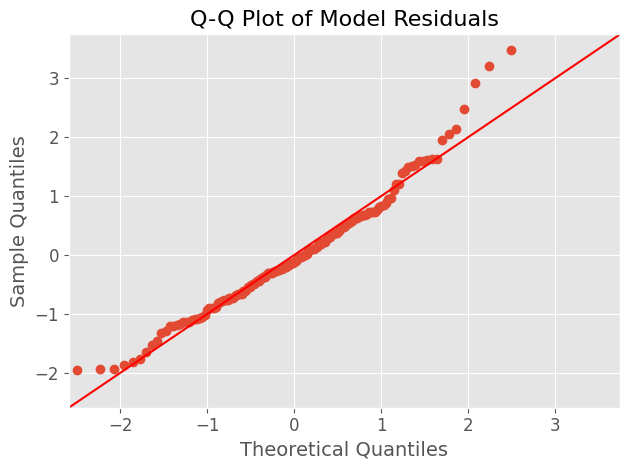

In [43]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Data Loading and Preparation
# ---------------------------
# Use the inferred dataset so that monthly GDP values are available.
df = pd.read_csv("allDataInferredGDP.csv")

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Sort data by Date
df.sort_values(by='Date', inplace=True)

# Define the full set of predictors, excluding ChamberParty.
# Numeric predictors: CPIChange, UnemploymentRate, GDP, GDPchange, PctVotes
# Categorical predictors: PrezParty, Chamber
# Note: ChamberParty has been removed.
predictors = ["CPIChange", "UnemploymentRate", "GDP", "GDPchange", "PctVotes",
              "C(PrezParty)", "C(Chamber)"]

# When dropping rows with missing values, use the actual column names (without C())
key_vars = ["Approval", "CPIChange", "UnemploymentRate", "GDP", "GDPchange", "PctVotes", "PrezParty", "Chamber"]
df_reg = df.dropna(subset=key_vars)

# ---------------------------
# 2. Full Regression Model with All Predictors (Excluding ChamberParty)
# ---------------------------
# Build the regression formula using the predictors defined above.
formula_full = "Approval ~ " + " + ".join(predictors)

# Fit the full model.
full_model = smf.ols(formula=formula_full, data=df_reg).fit()
print("Full Model Summary (without ChamberParty):")
print(full_model.summary())

# ---------------------------
# 3. Backward Elimination Function
# ---------------------------
def backward_elimination(data, response, predictors, significance_level=0.05):
    """
    Perform backward elimination on a set of predictors for an OLS model.
    Categorical predictors (specified as "C(Var)") are handled by computing the maximum p-value
    among all their dummy coefficients.
    Returns the final model and the list of remaining predictors.
    """
    import copy
    remaining_predictors = copy.deepcopy(predictors)

    while True:
        formula = response + ' ~ ' + ' + '.join(remaining_predictors)
        model = smf.ols(formula, data=data).fit()

        # Create a dictionary to store maximum p-values for each predictor.
        pvals_dict = {}
        for pred in remaining_predictors:
            if pred.startswith("C("):
                # For categorical predictors, get all dummy coefficient p-values.
                coefs = [coef for coef in model.pvalues.index if coef.startswith(pred)]
                if len(coefs) > 0:
                    pvals_dict[pred] = max(model.pvalues[coefs])
                else:
                    pvals_dict[pred] = 0
            else:
                # For numeric predictors, use the direct p-value.
                if pred in model.pvalues:
                    pvals_dict[pred] = model.pvalues[pred]
                else:
                    pvals_dict[pred] = 0

        # Find the predictor with the highest p-value.
        max_pred = max(pvals_dict, key=pvals_dict.get)
        max_pval = pvals_dict[max_pred]

        if max_pval > significance_level:
            print(f"Excluding {max_pred} (max p-value = {max_pval:.4f})")
            remaining_predictors.remove(max_pred)
        else:
            break

    final_formula = response + ' ~ ' + ' + '.join(remaining_predictors)
    final_model = smf.ols(final_formula, data=data).fit()
    return final_model, remaining_predictors

# ---------------------------
# 4. Run Backward Elimination
# ---------------------------
initial_predictors = predictors  # All predictors (without ChamberParty)
final_model, selected_predictors = backward_elimination(df_reg, "Approval", initial_predictors)
print("\nFinal Model Summary after Backward Elimination (without ChamberParty):")
print(final_model.summary())
print("\nSelected predictors:", selected_predictors)

# ---------------------------
# 5. Regression Diagnostics
# ---------------------------
# Residuals vs. Fitted Values Plot
plt.figure(figsize=(10,8))
plt.scatter(final_model.fittedvalues, final_model.resid,
            color='steelblue', edgecolor='black', s=70, alpha=0.8)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.title("Residuals vs. Fitted Values", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Q-Q Plot to assess normality of residuals
fig = sm.qqplot(final_model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Model Residuals", fontsize=16)
plt.xlabel("Theoretical Quantiles", fontsize=14)
plt.ylabel("Sample Quantiles", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Regression Analysis Excluding GDP

In this section, we present the results of our regression model that excludes GDP from the set of predictors. By removing GDP, we assess whether other economic and political factors (such as CPIChange, UnemploymentRate, GDPchange, PctVotes, and categorical variables like PrezParty and Chamber) can explain presidential approval ratings effectively on their own.

*Key points:*
- GDP is excluded to test its unique contribution.
- The model is compared against the one including GDP to evaluate changes in model performance.
- Backward elimination is used for variable selection, and diagnostic plots are provided.


<ipython-input-44-cd5db566e5b1>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Full Model Summary (without GDP):
                            OLS Regression Results                            
Dep. Variable:               Approval   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.267
Date:                Mon, 24 Mar 2025   Prob (F-statistic):             0.0507
Time:                        02:14:03   Log-Likelihood:                -596.55
No. Observations:                 157   AIC:                             1205.
Df Residuals:                     151   BIC:                             1223.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

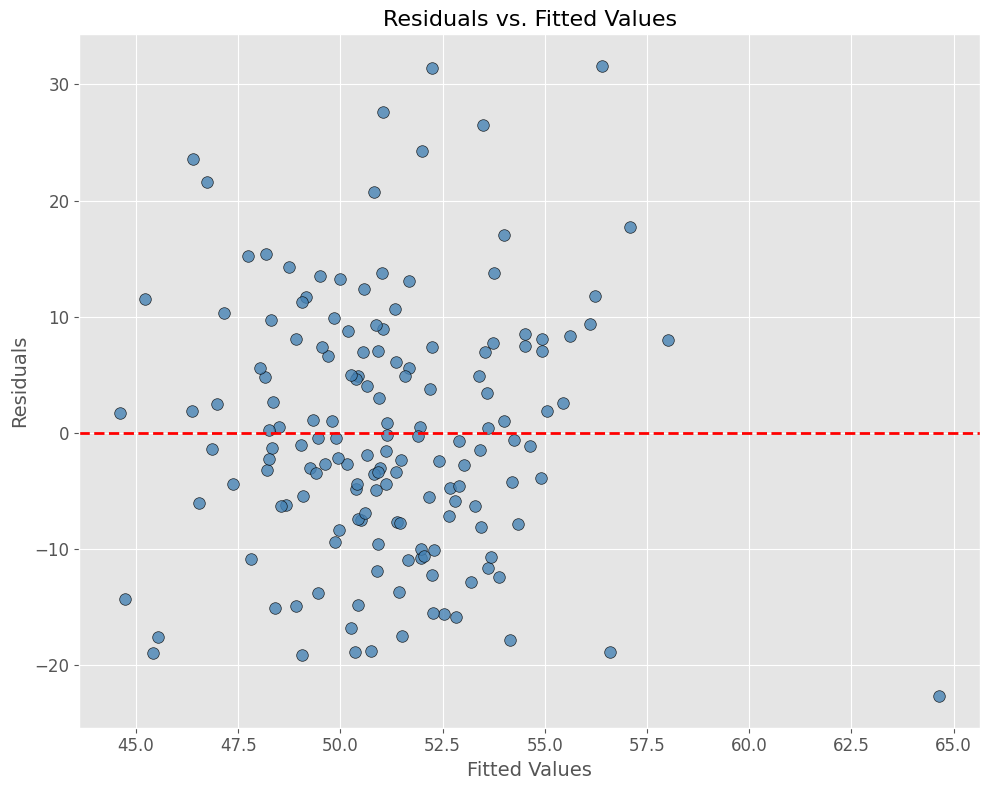

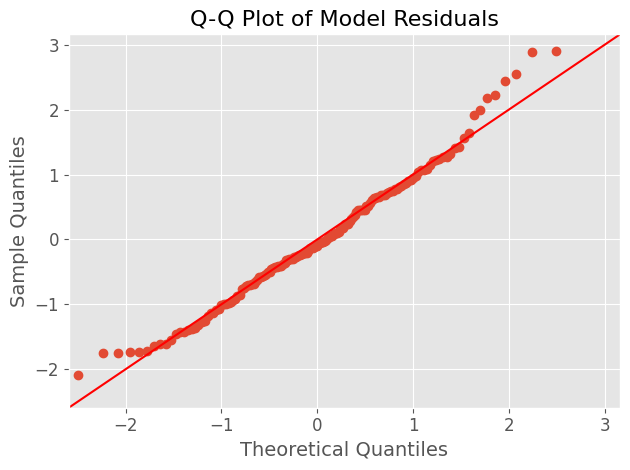

In [44]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ---------------------------
# 1. Data Loading and Preparation
# ---------------------------
# Load the inferred dataset (with inferred monthly GDP values, though we'll exclude GDP from predictors)
df = pd.read_csv("allDataInferredGDP.csv")

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Sort by Date (optional but recommended)
df.sort_values(by='Date', inplace=True)

# Define predictors WITHOUT GDP:
# Numeric predictors: CPIChange, UnemploymentRate, GDPchange, PctVotes
# Categorical predictors: PrezParty, Chamber
predictors = ["CPIChange", "UnemploymentRate", "GDPchange", "PctVotes",
              "C(PrezParty)", "C(Chamber)"]

# When dropping rows with missing values, use the actual column names (for numeric variables, drop 'GDP' as well)
key_vars = ["Approval", "CPIChange", "UnemploymentRate", "GDPchange", "PctVotes", "PrezParty", "Chamber"]
df_reg = df.dropna(subset=key_vars)

# ---------------------------
# 2. Full Regression Model Without GDP
# ---------------------------
formula_full = "Approval ~ " + " + ".join(predictors)
full_model = smf.ols(formula=formula_full, data=df_reg).fit()
print("Full Model Summary (without GDP):")
print(full_model.summary())

# ---------------------------
# 3. Backward Elimination Function (with Categorical Handling)
# ---------------------------
def backward_elimination(data, response, predictors, significance_level=0.05):
    """
    Perform backward elimination on a set of predictors for an OLS model.
    Categorical predictors (specified as "C(Var)") are handled by computing the maximum p-value
    among all their dummy coefficients.
    Returns the final model and the list of remaining predictors.
    """
    import copy
    remaining_predictors = copy.deepcopy(predictors)

    while True:
        formula = response + ' ~ ' + ' + '.join(remaining_predictors)
        model = smf.ols(formula, data=data).fit()

        # Build a dictionary of maximum p-values for each predictor
        pvals_dict = {}
        for pred in remaining_predictors:
            if pred.startswith("C("):
                # Get all coefficients related to the categorical predictor
                coefs = [coef for coef in model.pvalues.index if coef.startswith(pred)]
                if len(coefs) > 0:
                    pvals_dict[pred] = max(model.pvalues[coefs])
                else:
                    pvals_dict[pred] = 0
            else:
                if pred in model.pvalues:
                    pvals_dict[pred] = model.pvalues[pred]
                else:
                    pvals_dict[pred] = 0

        # Identify the predictor with the highest p-value
        max_pred = max(pvals_dict, key=pvals_dict.get)
        max_pval = pvals_dict[max_pred]

        if max_pval > significance_level:
            print(f"Excluding {max_pred} (max p-value = {max_pval:.4f})")
            remaining_predictors.remove(max_pred)
        else:
            break

    final_formula = response + ' ~ ' + ' + '.join(remaining_predictors)
    final_model = smf.ols(final_formula, data=data).fit()
    return final_model, remaining_predictors

# ---------------------------
# 4. Run Backward Elimination
# ---------------------------
initial_predictors = predictors  # predictors without GDP
final_model, selected_predictors = backward_elimination(df_reg, "Approval", initial_predictors)
print("\nFinal Model Summary after Backward Elimination (without GDP):")
print(final_model.summary())
print("\nSelected predictors:", selected_predictors)

# ---------------------------
# 5. Regression Diagnostics
# ---------------------------
# Residuals vs. Fitted Values Plot
plt.figure(figsize=(10,8))
plt.scatter(final_model.fittedvalues, final_model.resid,
            color='steelblue', edgecolor='black', s=70, alpha=0.8)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.title("Residuals vs. Fitted Values", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Q-Q Plot for Normality of Residuals
fig = sm.qqplot(final_model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Model Residuals", fontsize=16)
plt.xlabel("Theoretical Quantiles", fontsize=14)
plt.ylabel("Sample Quantiles", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
